# 梯度下降 
（[Boyd & Vandenberghe, 2004](https://d2l.ai/chapter_references/zreferences.html#boyd-vandenberghe-2004)）

In [1]:
%matplotlib inline
import numpy as np
import torch
import time
from torch import nn, optim
import math
import sys
sys.path.append('../')
import d2lzh1981 as d2l

## 一维梯度下降

**证明：沿梯度反方向移动自变量可以减小函数值**

泰勒展开：

$$
f(x+\epsilon)=f(x)+\epsilon f^{\prime}(x)+\mathcal{O}\left(\epsilon^{2}\right)
$$

代入沿梯度方向的移动量 $\eta f^{\prime}(x)$：

$$
f\left(x-\eta f^{\prime}(x)\right)=f(x)-\eta f^{\prime 2}(x)+\mathcal{O}\left(\eta^{2} f^{\prime 2}(x)\right)
$$

$$
f\left(x-\eta f^{\prime}(x)\right) \lesssim f(x)
$$


$$
x \leftarrow x-\eta f^{\prime}(x)
$$

e.g.

$$
f(x) = x^2
$$

In [2]:
def f(x):
    return x**2  # Objective function

def gradf(x):
    return 2 * x  # Its derivative

def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * gradf(x)
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(0.2)

epoch 10, x: 0.06046617599999997


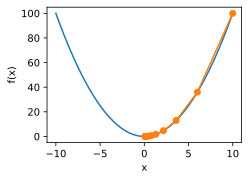

In [3]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)))
    f_line = np.arange(-n, n, 0.01)
    d2l.set_figsize((3.5, 2.5))
    d2l.plt.plot(f_line, [f(x) for x in f_line],'-')
    d2l.plt.plot(res, [f(x) for x in res],'-o')
    d2l.plt.xlabel('x')
    d2l.plt.ylabel('f(x)')
    

show_trace(res)

### 学习率

epoch 10, x: 3.4867844009999995


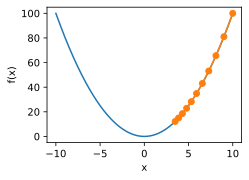

In [4]:
show_trace(gd(0.05))

epoch 10, x: 61.917364224000096


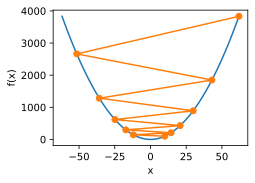

In [5]:
show_trace(gd(1.1))

### 局部极小值

e.g.

$$
f(x) = x\cos cx
$$

epoch 10, x: -1.5281659276350823


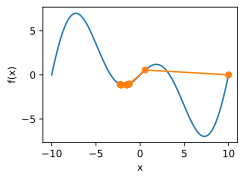

In [6]:
c = 0.15 * np.pi

def f(x):
    return x * np.cos(c * x)

def gradf(x):
    return np.cos(c * x) - c * x * np.sin(c * x)

show_trace(gd(2))

## 多维梯度下降

In [7]:
def train_2d(trainer, steps=20):
    x1, x2 = -5, -2
    results = [(x1, x2)]
    for i in range(steps):
        x1, x2 = trainer(x1, x2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def show_trace_2d(f, results): 
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20, x1 -0.057646, x2 -0.000073


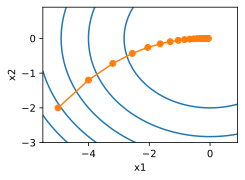

In [8]:
eta = 0.1

def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2):
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2)

show_trace_2d(f_2d, train_2d(gd_2d))

## 自适应方法

### 牛顿法

在 $x + \epsilon$ 处泰勒展开：

$$
f(\mathbf{x}+\epsilon)=f(\mathbf{x})+\epsilon^{\top} \nabla f(\mathbf{x})+\frac{1}{2} \epsilon^{\top} \nabla \nabla^{\top} f(\mathbf{x}) \epsilon+\mathcal{O}\left(\|\epsilon\|^{3}\right)
$$

最小值点处满足: $\nabla f(\mathbf{x})=0$, 即我们希望 $\nabla f(\mathbf{x} + \epsilon)=0$, 对上式关于 $\epsilon$ 求导，忽略高阶无穷小，有：

$$
\nabla f(\mathbf{x})+\boldsymbol{H}_{f} \boldsymbol{\epsilon}=0 \text { and hence } \epsilon=-\boldsymbol{H}_{f}^{-1} \nabla f(\mathbf{x})
$$

epoch 10, x: 0.0


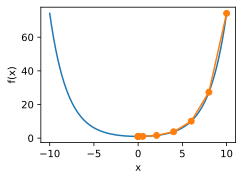

In [9]:
c = 0.5

def f(x):
    return np.cosh(c * x)  # Objective

def gradf(x):
    return c * np.sinh(c * x)  # Derivative

def hessf(x):
    return c**2 * np.cosh(c * x)  # Hessian

# Hide learning rate for now
def newton(eta=1):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * gradf(x) / hessf(x)
        results.append(x)
    print('epoch 10, x:', x)
    return results

show_trace(newton())

epoch 10, x: 26.83413291324767


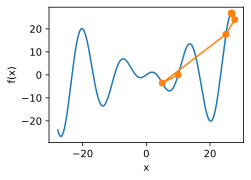

In [10]:
c = 0.15 * np.pi

def f(x):
    return x * np.cos(c * x)

def gradf(x):
    return np.cos(c * x) - c * x * np.sin(c * x)

def hessf(x):
    return - 2 * c * np.sin(c * x) - x * c**2 * np.cos(c * x)

show_trace(newton())

epoch 10, x: 7.269860168684531


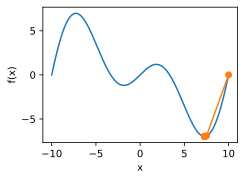

In [11]:
show_trace(newton(0.5))

### 收敛性分析

只考虑在函数为凸函数, 且最小值点上 $f''(x^*) > 0$ 时的收敛速度：

令 $x_k$ 为第 $k$ 次迭代后 $x$ 的值， $e_{k}:=x_{k}-x^{*}$ 表示 $x_k$ 到最小值点 $x^{*}$ 的距离，由 $f'(x^{*}) = 0$:

$$
0=f^{\prime}\left(x_{k}-e_{k}\right)=f^{\prime}\left(x_{k}\right)-e_{k} f^{\prime \prime}\left(x_{k}\right)+\frac{1}{2} e_{k}^{2} f^{\prime \prime \prime}\left(\xi_{k}\right) \text{for some } \xi_{k} \in\left[x_{k}-e_{k}, x_{k}\right]
$$

两边除以 $f''(x_k)$, 有：

$$
e_{k}-f^{\prime}\left(x_{k}\right) / f^{\prime \prime}\left(x_{k}\right)=\frac{1}{2} e_{k}^{2} f^{\prime \prime \prime}\left(\xi_{k}\right) / f^{\prime \prime}\left(x_{k}\right)
$$

代入更新方程 $x_{k+1} = x_{k} - f^{\prime}\left(x_{k}\right) / f^{\prime \prime}\left(x_{k}\right)$, 得到：

$$
x_k - x^{*} - f^{\prime}\left(x_{k}\right) / f^{\prime \prime}\left(x_{k}\right) =\frac{1}{2} e_{k}^{2} f^{\prime \prime \prime}\left(\xi_{k}\right) / f^{\prime \prime}\left(x_{k}\right)
$$


$$
x_{k+1} - x^{*} = e_{k+1} = \frac{1}{2} e_{k}^{2} f^{\prime \prime \prime}\left(\xi_{k}\right) / f^{\prime \prime}\left(x_{k}\right)
$$

当 $\frac{1}{2} f^{\prime \prime \prime}\left(\xi_{k}\right) / f^{\prime \prime}\left(x_{k}\right) \leq c$ 时，有:

$$
e_{k+1} \leq c e_{k}^{2}
$$

### 预处理 （Heissan阵辅助梯度下降）


$$
\mathbf{x} \leftarrow \mathbf{x}-\eta \operatorname{diag}\left(H_{f}\right)^{-1} \nabla \mathbf{x}
$$

### 梯度下降与线性搜索（共轭梯度法）

# 随机梯度下降

## 随机梯度下降参数更新

对于有 $n$ 个样本对训练数据集，设 $f_i(x)$ 是第 $i$ 个样本的损失函数, 则目标函数为:

$$
f(\mathbf{x})=\frac{1}{n} \sum_{i=1}^{n} f_{i}(\mathbf{x})
$$

其梯度为:

$$
\nabla f(\mathbf{x})=\frac{1}{n} \sum_{i=1}^{n} \nabla f_{i}(\mathbf{x})
$$

使用该梯度的一次更新的时间复杂度为 $\mathcal{O}(n)$

随机梯度下降更新公式 $\mathcal{O}(1)$:

$$
\mathbf{x} \leftarrow \mathbf{x}-\eta \nabla f_{i}(\mathbf{x})
$$

且有：

$$
\mathbb{E}_{i} \nabla f_{i}(\mathbf{x})=\frac{1}{n} \sum_{i=1}^{n} \nabla f_{i}(\mathbf{x})=\nabla f(\mathbf{x})
$$

e.g. 

$$
f(x_1, x_2) = x_1^2 + 2 x_2^2
$$

epoch 50, x1 0.267653, x2 -0.154400


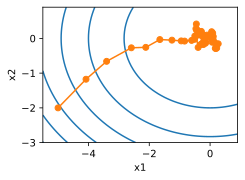

In [12]:
def f(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2  # Objective

def gradf(x1, x2):
    return (2 * x1, 4 * x2)  # Gradient

def sgd(x1, x2):  # Simulate noisy gradient
    global lr  # Learning rate scheduler
    (g1, g2) = gradf(x1, x2)  # Compute gradient
    (g1, g2) = (g1 + np.random.normal(0.1), g2 + np.random.normal(0.1))
    eta_t = eta * lr()  # Learning rate at time t
    return (x1 - eta_t * g1, x2 - eta_t * g2)  # Update variables

eta = 0.1
lr = (lambda: 1)  # Constant learning rate
show_trace_2d(f, train_2d(sgd, steps=50))

## 动态学习率


$$
\begin{array}{ll}{\eta(t)=\eta_{i} \text { if } t_{i} \leq t \leq t_{i+1}} & {\text { piecewise constant }} \\ {\eta(t)=\eta_{0} \cdot e^{-\lambda t}} & {\text { exponential }} \\ {\eta(t)=\eta_{0} \cdot(\beta t+1)^{-\alpha}} & {\text { polynomial }}\end{array}
$$

epoch 1000, x1 -0.858199, x2 -0.100814


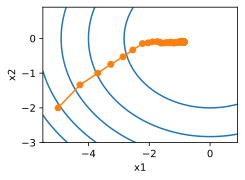

In [13]:
def exponential():
    global ctr
    ctr += 1
    return math.exp(-0.1 * ctr)

ctr = 1
lr = exponential  # Set up learning rate
show_trace_2d(f, train_2d(sgd, steps=1000))

epoch 50, x1 -0.055297, x2 0.014592


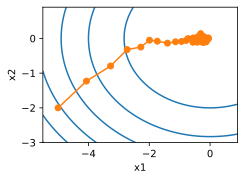

In [14]:
def polynomial():
    global ctr
    ctr += 1
    return (1 + 0.1 * ctr)**(-0.5)

ctr = 1
lr = polynomial  # Set up learning rate
show_trace_2d(f, train_2d(sgd, steps=50))

# 小批量随机梯度下降

## 读取数据
[读取数据](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise)

In [42]:
def get_data_ch7():  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    data = np.genfromtxt('../../data/airfoil4755/airfoil_self_noise.dat', delimiter='\t', encoding='utf-8')
    data = (data - data.mean(axis=0)) / data.std(axis=0) # 标准化
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
           torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

features, labels = get_data_ch7()
features.shape
features

tensor([[-0.5989, -1.1473,  1.8018,  1.3141, -0.6451],
        [-0.5196, -1.1473,  1.8018,  1.3141, -0.6451],
        [-0.4085, -1.1473,  1.8018,  1.3141, -0.6451],
        ...,
        [-0.1230,  1.4898, -0.3728, -0.7226,  3.1717],
        [ 0.0832,  1.4898, -0.3728, -0.7226,  3.1717],
        [ 0.3529,  1.4898, -0.3728, -0.7226,  3.1717]])

In [41]:
import pandas as pd
df = pd.read_csv('../../data/airfoil4755/airfoil_self_noise.dat', delimiter='\t', header=None)
df.head(10)

,0,1,2,3,4,5
0,1000,0.0,0.3048,71.3,0.002663,125.201
1,1250,0.0,0.3048,71.3,0.002663,125.951
2,1600,0.0,0.3048,71.3,0.002663,127.591
3,2000,0.0,0.3048,71.3,0.002663,127.461
4,2500,0.0,0.3048,71.3,0.002663,125.571
5,3150,0.0,0.3048,71.3,0.002663,125.201
6,4000,0.0,0.3048,71.3,0.002663,123.061
7,5000,0.0,0.3048,71.3,0.002663,121.301
8,6300,0.0,0.3048,71.3,0.002663,119.541
9,8000,0.0,0.3048,71.3,0.002663,117.151


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
0    1502 non-null int64
1    1502 non-null float64
2    1502 non-null float64
3    1502 non-null float64
4    1502 non-null float64
5    1502 non-null float64
dtypes: float64(5), int64(1)
memory usage: 70.5 KB


## 从零开始实现

In [23]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

In [44]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = d2l.linreg, d2l.squared_loss
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    print(ls)
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()  # 使用平均损失
            
            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
                
            l.backward()
            optimizer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

In [25]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

对比

[0.4964454770088196]
loss: 0.244812, 0.036413 sec per epoch


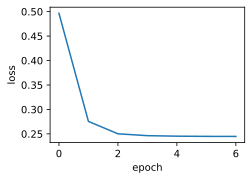

In [45]:
train_sgd(1, 1500, 6)

[0.49547046422958374]
loss: 0.243334, 1.428877 sec per epoch


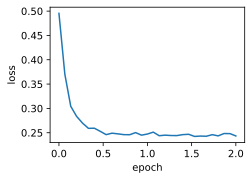

In [46]:
train_sgd(0.005, 1)

[0.49098309874534607]
loss: 0.243484, 0.160541 sec per epoch


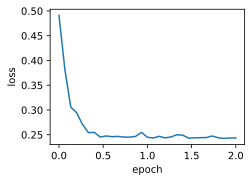

In [47]:
train_sgd(0.05, 10)

## 简洁实现

In [48]:
# 本函数与原书不同的是这里第一个参数优化器函数而不是优化器的名字
# 例如: optimizer_fn=torch.optim.SGD, optimizer_hyperparams={"lr": 0.05}
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.242464, 0.140413 sec per epoch


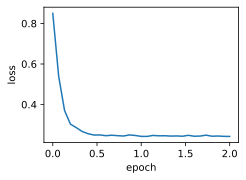

In [49]:
train_pytorch_ch7(optim.SGD, {"lr": 0.05}, features, labels, 10)